# Grouptimus Prime
## Phase 2 Project

In [1]:
#Importing libraries 
import pandas as pd
import seaborn as sns
import numpy as np
import scipy.stats as stats
from sklearn.model_selection import cross_validate, ShuffleSplit,train_test_split
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from statsmodels.formula.api import ols
from statsmodels.regression.linear_model import OLS
import statsmodels.api as sm
import sklearn.metrics as metrics
from sklearn.metrics import mean_squared_error
from statsmodels.stats.outliers_influence import variance_inflation_factor 
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.dummy import DummyRegressor
import warnings

In [2]:
#Import dataset
dataset = pd.read_csv('data/kc_house_data.csv')

## Cleaning the dataset

In [3]:
# Filling nulls with most common value
dataset['waterfront'] = dataset['waterfront'].fillna(0) 
# Drop how many times house viewed
dataset.dropna(subset = ['view'], inplace = True)
# Make values with no house renovation the year it was built
dataset.yr_renovated.fillna(dataset.yr_built, inplace=True)
# Make sqft basement a float and fill na with 0 
dataset['sqft_basement'] = dataset['sqft_basement'].replace('?', np.nan).astype(float).fillna(0)

# Heatmap for a quick look at where we might start

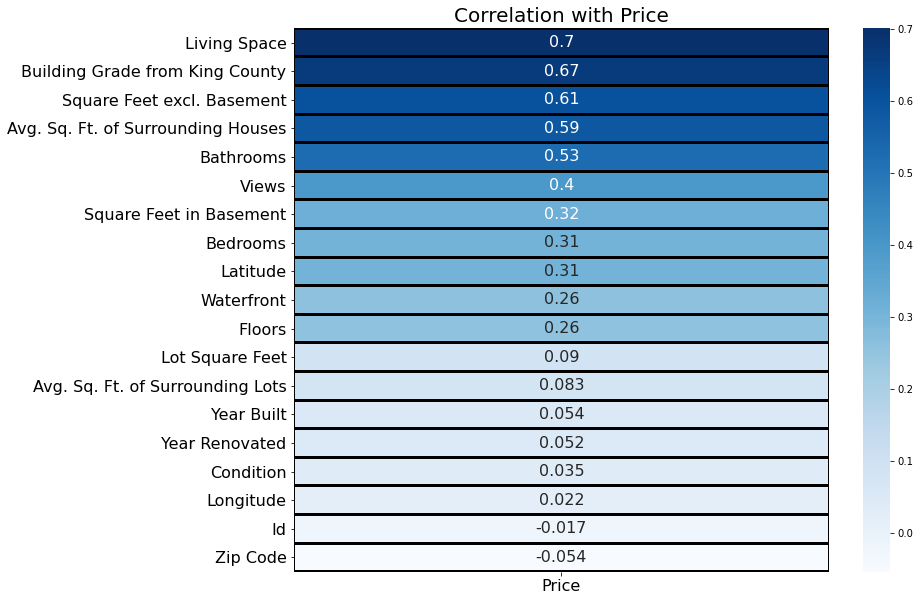

In [4]:
x_label_ticks = ['Living Space', 'Building Grade from King County', 'Square Feet excl. Basement', 'Avg. Sq. Ft. of Surrounding Houses', 'Bathrooms', 'Views', 'Square Feet in Basement', 'Bedrooms', 'Latitude', 'Waterfront', 'Floors', 'Lot Square Feet', 'Avg. Sq. Ft. of Surrounding Lots', 'Year Built', 'Year Renovated', 'Condition', 'Longitude', 'Id', 'Zip Code']
corr = dataset.corr().drop(['price'])
x=corr[['price']]
fig , ax = plt.subplots(figsize=(12,10))
sns.heatmap(x.sort_values(by=['price'],ascending=0),
                          annot=True,
                          cmap='Blues',
                          annot_kws={'fontsize':16},
                          linewidth=2,
                          linecolor='black',
                          yticklabels= x_label_ticks,
                            xticklabels = ['Price'])
ax.set_title('Correlation with Price',size=20)
ax.tick_params(labelsize=16)

 It seems like Living Space (column name of sqft_living) has the highest correlation with price. This and grade seem to be the two highest, but grade is categorical (technically) and sqft is numerical.

# Looking at score with most correlated feature

Here we run a first model to see where we are.

In [5]:
X = dataset['sqft_living']
y= dataset['price']
#Splitting our data into train sets and test sets

X_train,X_test,Y_train,Y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Have to reshape in order for test to work
X_train = np.array(X_train).reshape(-1,1)
Y_train = np.array(Y_train).reshape(-1,1)
X_test = np.array(X_test).reshape(-1,1)
Y_test = np.array(Y_test).reshape(-1,1)


model = LinearRegression()
model.fit(X_train,Y_train)

Y_pred = model.predict(X_test)

print(f"""Train Score: {round(model.score(X_train, Y_train),4)}
Test Score:  {round(model.score(X_test, Y_test),4)}""")

Train Score: 0.4839
Test Score:  0.5206


This model performed poorly. We will need to look at other features.

# Exploring Price Data

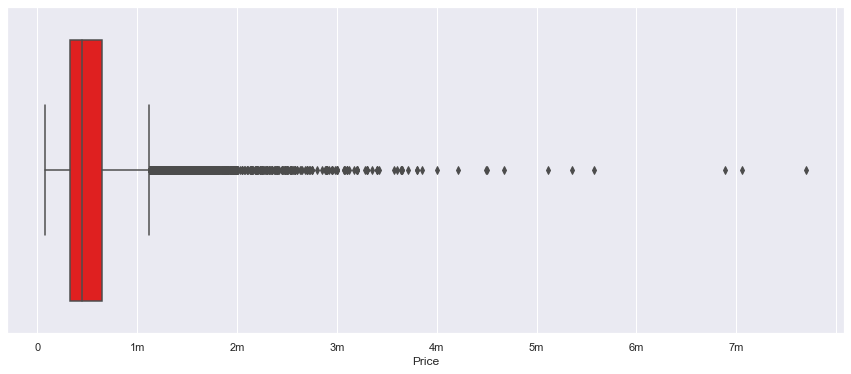

In [7]:
#Checking the distribution of house prices

fig, ax = plt.subplots(figsize = (15, 6))
sns.boxplot(dataset['price'], color='red')
sns.set(style='darkgrid')
plt.xlabel('Price')
ax.set_xticklabels(['', '0', '1m', '2m', '3m', '4m', '5m','6m','7m']);
warnings.filterwarnings('ignore')

This Boxplot is telling us that most of the data does not exceed a little over 1 million.

Let's remove the outliers and take a closer look at where the data lands.

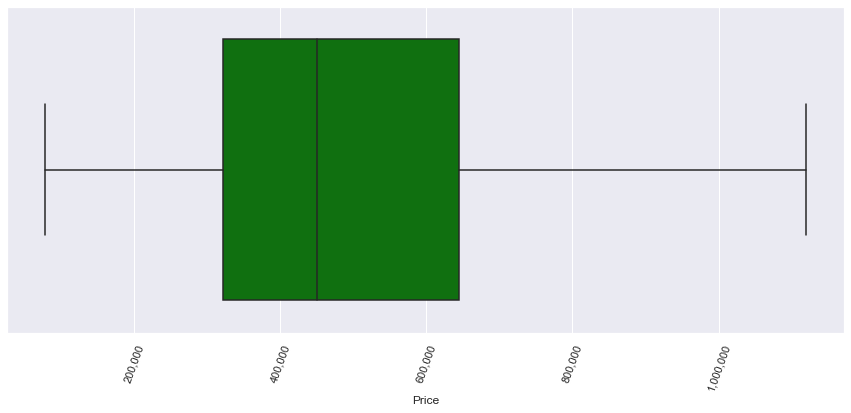

In [8]:
fig, ax = plt.subplots(figsize = (15, 6))
sns.boxplot(dataset['price'], showfliers = False, color='green')
sns.set(style='darkgrid')
plt.xlabel('Price')
ax.tick_params(axis='x', rotation=70)
ax.set_xticklabels(['0', '200,000', '400,000', '600,000', '800,000', '1,000,000', '1,200,000']);
warnings.filterwarnings('ignore')

Knowing this, let's round off our max price variable at $1,200,000 which is slightly above the end of the Boxplot whisker

In [9]:
dataset_full = dataset['price'].shape[0]
no_outliers = dataset[(dataset['price'] <= 1200000)]
no_outliers_num = no_outliers.shape[0]

In [10]:
percent_outlier = 1-(no_outliers_num/dataset_full)
round(percent_outlier, 4)

0.0452

Taking out these outliers will remove about 4.5% of the data.

We'll revisit this parameter while creating the final model.

# Exploration of grade

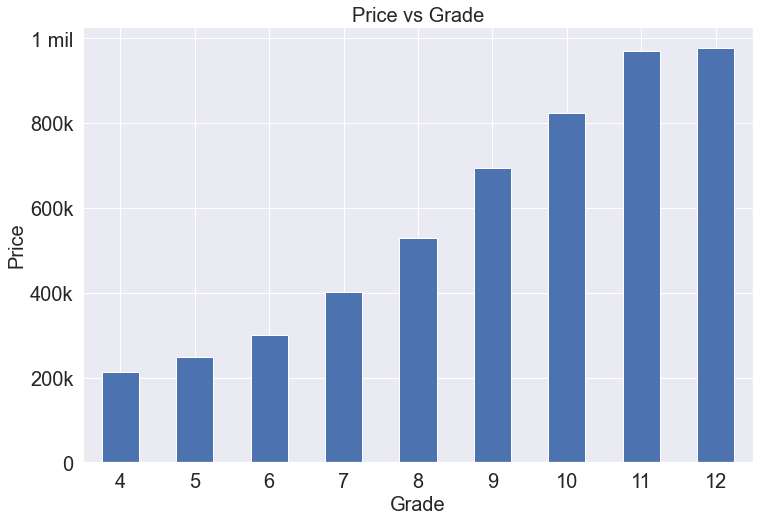

In [11]:
columns = ['price','bedrooms','bathrooms','sqft_living','sqft_lot','condition','grade','sqft_living15','sqft_lot15']
dataset = dataset[dataset['price'] < 1200000]

df_grade = dataset.groupby('grade').mean().sort_values(by=['grade'])
grade_df = pd.DataFrame(df_grade,columns=columns)
grade_df.drop(grade_df.index[0],axis=0,inplace=True)

price_df = grade_df['price']
fig ,ax = plt.subplots(figsize=(12,8))

price_df.plot.bar()
ax.set_title('Price vs Grade',fontsize=20)
ax.set_ylabel('Price',fontsize=20)
ax.set_xlabel('Grade',fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax.set_yticklabels(['0','200k','400k','600k','800k','1 mil'])
ax.tick_params(axis='x', rotation=360);
plt.savefig('Price vs Grade')

The trend appears to be the higher the grade of the house, the higher the price is. This will be a good variable to help predict the price of houses.

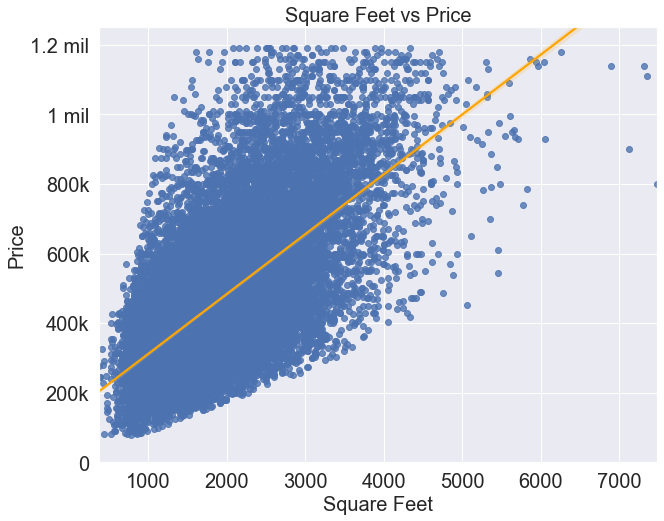

In [12]:
dataset = dataset[dataset['price'] <= 1200000]

fig , ax = plt.subplots(figsize=(10,8))
sns.regplot(x=dataset['sqft_living'],y=dataset['price'],line_kws={'color': 'orange'})
ax.set_ylim([0,1250000])
ax.set_title('Square Feet vs Price',fontsize=20)
ax.set_ylabel('Price',fontsize=20)
ax.set_xlabel('Square Feet',fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax.set_yticklabels(['0','200k','400k','600k','800k','1 mil','1.2 mil']);
plt.savefig('SqFt Price')

The more square footage a house has, the higher the price.

# Test Two Highest Correlated Features

In [13]:
X = pd.DataFrame(dataset,columns = ['sqft_living','grade'])
y = dataset['price']

In [14]:
#Split Data into training and test sets

X_train,X_test,Y_train,Y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Use a scaler for our X values
Scaler = StandardScaler()
X_train = Scaler.fit(X_train).transform(X_train)

#Fit Training data to linear model
model = LinearRegression()
model.fit(X_train,Y_train)

# Predict the Y outcomes off our test set
Y_pred = model.predict(Scaler.transform(X_test))

model.coef_,model.intercept_,

print(f"""Train Score: {round(model.score(X_train,Y_train),4)}
Test Score: {round(metrics.r2_score(Y_pred,Y_test),4)}""")

Train Score: 0.4697
Test Score: -0.1254


The train score is lower and the test score is frankly awful.

Let's do a little more investigation and find out what's causing this error.

In [15]:
formula1 = 'price ~ sqft_living + grade '
model = ols(formula1, data=dataset)
model.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.471
Model:                            OLS   Adj. R-squared:                  0.471
Method:                 Least Squares   F-statistic:                     9130.
Date:                Fri, 27 Aug 2021   Prob (F-statistic):               0.00
Time:                        14:53:40   Log-Likelihood:            -2.7449e+05
No. Observations:               20520   AIC:                         5.490e+05
Df Residuals:                   20517   BIC:                         5.490e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept   -3.091e+05   8871.524    -34.845      0.000   -3.27e+05   -2.92e+05
sqft_living    96.5373      1.972     48.947      0.000      92.671     100.403
grade        7.937e+04   1477.816     53.710      0.000    7.65e+04    8.23e+04
==============================================================================
Omnibus:                     1476.611   Durbin-Watson:                   1.968
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1897.687
Skew:                           0.658   Prob(JB):                         0.00
Kurtosis:                       3.697   Cond. No.                     1.76e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.76e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

The model shows improvements, but more investigation is needed.

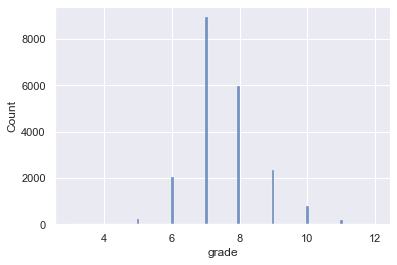

In [16]:
sns.histplot(dataset['grade']);

After graphing, we can see that grade is a categorical variable and we will need to create dummy variables. 

In [17]:
# Creating dummy columns for grade variable, and
# then joined our original dataset with dummy columns
dummy_df = dataset['grade']
dummies = pd.get_dummies(dummy_df,prefix='grade',drop_first=True)
merged = pd.concat([dataset,dummies],axis=1)
merged.drop('grade',axis=1,inplace=True)

# Investigating zip codes

In [18]:
# Replaced zip code values with the mean price of the entire zip code
df_zip = dataset.groupby('zipcode').mean().sort_values(by=['price'],ascending=False)
new_df = pd.DataFrame(df_zip,columns=columns)
new_df

,price,bedrooms,bathrooms,sqft_living,sqft_lot,condition,grade,sqft_living15,sqft_lot15
zipcode,,,,,,,,,
98039,937857.142857,3.285714,1.642857,1692.857143,10905.285714,3.714286,7.428571,2478.571429,10848.142857
98040,859364.713450,3.812865,2.305556,2520.269006,12377.959064,3.877193,8.350877,2648.654971,11641.473684
98004,856767.515337,3.484663,1.978528,2037.607362,10894.257669,3.613497,7.699387,2327.668712,10808.092025
98005,757507.445860,3.821656,2.358280,2540.254777,18084.745223,3.732484,8.312102,2489.108280,17414.878981
98112,755271.308989,3.219101,1.998596,1939.213483,3880.696629,3.398876,7.876404,1902.421348,4006.056180
...,...,...,...,...,...,...,...,...,...
98023,283999.317814,3.423077,2.052632,1979.293522,10421.103239,3.390688,7.564777,1960.706478,9745.489879
98001,280881.192201,3.392758,2.013231,1901.743733,14978.727019,3.337047,7.292479,1829.292479,11230.228412
98032,251017.177419,3.379032,1.709677,1738.435484,10401.169355,3.629032,7.145161,1668.459677,9284.290323


We will use the average price per zip code to help predict price of houses


# Second Model

### Testing new features

In [19]:
#Adding condition to see if any major improvements are found
X=merged.drop(['id','date','lat','yr_renovated','long','view','sqft_lot','sqft_above','sqft_living15','price',
               'bathrooms','sqft_lot15','yr_built','bedrooms','sqft_basement','floors','condition'], axis = 1).select_dtypes(exclude = ['object', 'category'])
y = merged['price']

X_train,X_test,Y_train,Y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
ss = StandardScaler()
ss.fit(X).transform(X)

model.fit(X,y)

y_hat = model.predict(X_test)

resid = Y_test-y_hat

print(f"""Train Score: {round(model.score(X_train,Y_train),4)}
Test Score: {round(metrics.r2_score(y_hat,Y_test),4)}""")

Train Score: 0.4944
Test Score: -0.0147


In [20]:
formula2 = 'price ~ sqft_living + zipcode + waterfront + grade_4 + grade_5 + grade_6 + grade_7 + grade_8 + grade_9 + grade_10 + grade_11 + grade_12'
model = ols(formula2, data=merged)
model.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.495
Model:                            OLS   Adj. R-squared:                  0.494
Method:                 Least Squares   F-statistic:                     1673.
Date:                Fri, 27 Aug 2021   Prob (F-statistic):               0.00
Time:                        14:53:41   Log-Likelihood:            -2.7402e+05
No. Observations:               20520   AIC:                         5.481e+05
Df Residuals:                   20507   BIC:                         5.482e+05
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept   -4.917e+07   2.02e+06    -24.362      0.000   -5.31e+07   -4.52e+07
sqft_living    98.7494      1.952     50.598      0.000      94.924     102.575
zipcode       503.7477     20.529     24.538      0.000     463.509     543.987
waterfront    2.42e+05   2.01e+04     12.046      0.000    2.03e+05    2.81e+05
grade_4     -8.936e+04   1.55e+05     -0.575      0.565   -3.94e+05    2.15e+05
grade_5      -9.38e+04   1.53e+05     -0.614      0.539   -3.93e+05    2.06e+05
grade_6      -6.85e+04   1.53e+05     -0.449      0.653   -3.68e+05    2.31e+05
grade_7     -6815.3907   1.53e+05     -0.045      0.964   -3.06e+05    2.92e+05
grade_8      7.652e+04   1.53e+05      0.501      0.616   -2.23e+05    3.76e+05
grade_9      1.842e+05   1.53e+05      1.206      0.228   -1.15e+05    4.83e+05
grade_10     2.625e+05   1.53e+05      1.718      0.086   -3.69e+04    5.62e+05
grade_11     3.449e+05   1.53e+05      2.252      0.024    4.47e+04    6.45e+05
grade_12     2.639e+05   1.67e+05      1.577      0.115   -6.41e+04    5.92e+05
==============================================================================
Omnibus:                     1621.700   Durbin-Watson:                   1.966
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2228.685
Skew:                           0.670   Prob(JB):                         0.00
Kurtosis:                       3.902   Cond. No.                     1.86e+08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.86e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

This model explores Living Space, Waterfront, Zip Code, and Grades as dummy variables.

It shows some improvement on our test data, but we need to dig deeper.

# A Finalized Model

In [21]:
merged = merged[merged['price'] < 1200000]

#Create a column that has age of house
merged['house_age'] = 2014 - merged['yr_built']

X=merged.drop(['id','date','view','sqft_lot','sqft_above','sqft_living15','grade_7','yr_built'
               ,'sqft_lot15','sqft_basement','floors','condition'], axis = 1).select_dtypes(exclude = ['object', 'category'])
y = merged['price']

In [22]:
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#To avoid data leakage, the average price of zip codes is obtained only from the training set of data.
group = X_train.groupby('zipcode').mean().sort_values(by=['price'],ascending=False)
zip_group = group['price']

# Put values into a dictionary, then map a new column matching the average price of that zip code
zip_dict = zip_group.to_dict()
X_train['avg_zip_price'] = X_train['zipcode'].map(zip_dict)
warnings.filterwarnings('ignore')

In [23]:
# We put this data into the test set to make equal columns to run the test
X_test['avg_zip_price'] = X_test['zipcode'].map(zip_dict)

warnings.filterwarnings('ignore')

In [24]:
#Average price of bedrooms mapped to it's own column
group2 = X_train.groupby('bedrooms').mean().sort_values(by=['price'],ascending=False)
bedrooms_group = group2['price']
bed_dict = bedrooms_group.to_dict()
X_train['beds'] = X_train['bedrooms'].map(bed_dict)

In [25]:
# We put this data into the test set to make equal columns to run the test
X_test['avg_zip_price'] = X_test['zipcode'].map(zip_dict)
X_test['beds'] = X_test['bedrooms'].map(bed_dict)

warnings.filterwarnings('ignore')

In [26]:
# Checking the OLS of the unscaled model
formula_final = 'price ~ lat+long+ bedrooms +bathrooms+house_age+beds + sqft_living + waterfront + yr_renovated + zipcode +lat+long+ avg_zip_price + grade_4+ grade_5+grade_6+grade_8+grade_9+grade_10+grade_11+beds'
model = ols(formula_final, data=X_train)
model.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.795
Model:                            OLS   Adj. R-squared:                  0.795
Method:                 Least Squares   F-statistic:                     3540.
Date:                Fri, 27 Aug 2021   Prob (F-statistic):               0.00
Time:                        14:53:41   Log-Likelihood:            -2.1173e+05
No. Observations:               16416   AIC:                         4.235e+05
Df Residuals:                   16397   BIC:                         4.237e+05
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept     -2.454e+07   1.52e+06    -16.163      0.000   -2.75e+07   -2.16e+07
lat            9.135e+04   7357.425     12.416      0.000    7.69e+04    1.06e+05
long          -1.298e+05   6927.970    -18.739      0.000   -1.43e+05   -1.16e+05
bedrooms      -5134.0571   2296.860     -2.235      0.025   -9636.153    -631.962
bathrooms      2.239e+04   1768.491     12.661      0.000    1.89e+04    2.59e+04
house_age      1249.3563     37.038     33.731      0.000    1176.757    1321.955
beds             -0.0186      0.031     -0.600      0.549      -0.080       0.042
sqft_living     103.3980      1.856     55.704      0.000      99.760     107.036
waterfront     2.794e+05   1.36e+04     20.483      0.000    2.53e+05    3.06e+05
yr_renovated      2.0853      0.951      2.194      0.028       0.222       3.949
zipcode          42.4196     18.232      2.327      0.020       6.684      78.155
avg_zip_price     0.6994      0.007     96.065      0.000       0.685       0.714
grade_4       -6.863e+04   2.23e+04     -3.073      0.002   -1.12e+05   -2.49e+04
grade_5        -5.46e+04   7217.441     -7.565      0.000   -6.87e+04   -4.05e+04
grade_6       -4.152e+04   2866.910    -14.484      0.000   -4.71e+04   -3.59e+04
grade_8        5.274e+04   2079.658     25.360      0.000    4.87e+04    5.68e+04
grade_9        1.373e+05   3192.234     43.022      0.000    1.31e+05    1.44e+05
grade_10       1.843e+05   4914.346     37.502      0.000    1.75e+05    1.94e+05
grade_11       2.733e+05   9624.516     28.395      0.000    2.54e+05    2.92e+05
==============================================================================
Omnibus:                     2019.807   Durbin-Watson:                   1.993
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             6134.372
Skew:                           0.651   Prob(JB):                         0.00
Kurtosis:                       5.697   Cond. No.                     1.40e+09
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.4e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

With a high $r^2$, this is the best model that we will use.

In [27]:
# To avoid data leakage, use only the average from the training set and apply to testing set
# We first drop price from the X_train and X_test
X_test.drop('price',inplace= True,axis=1)
X_train.drop('price',inplace=True,axis=1)

In [28]:
# Check for Multicollinearity
vif = pd.DataFrame()
X = pd.DataFrame(X_train,columns=X_train.columns)
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
vif

,VIF Factor,features
0,1.111190e+02,bedrooms
1,2.597327e+01,bathrooms
2,2.762428e+01,sqft_living
3,1.012845e+00,waterfront
4,1.276046e+00,yr_renovated
5,1.423328e+06,zipcode
6,2.105799e+05,lat
7,1.257232e+06,long
8,1.011746e+00,grade_4
9,1.082552e+00,grade_5


# A visual representation of our Predicted Values vs the Actual Values

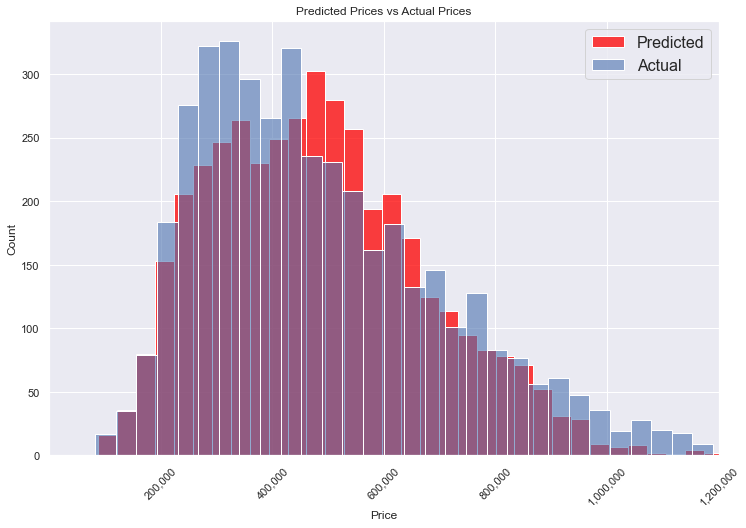

In [29]:
fig , axes = plt.subplots(nrows=1,ncols=1,figsize=(12,8))

model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
sns.histplot(y_pred,color='red',ax=axes,label='Predicted')
sns.histplot(y_test,alpha=.6,label='Actual')
axes.set_xlim([0,1200000])
axes.set_xlabel('price')
axes.set_title('Predicted Prices vs Actual Prices')
plt.legend(fontsize=16);
plt.savefig('Predicted vs Actual Stacked')

axes.tick_params(axis='x', rotation=45)
axes.set_xticklabels(['', '200,000', '400,000', '600,000', '800,000', '1,000,000', '1,200,000'])
axes.set_xlabel('Price')
plt.legend(fontsize=16);
warnings.filterwarnings('ignore')

This does a really good job of predicting the prices (~80%), as seen in the below test.

In [30]:
# Standard Test Cell

Scaler = StandardScaler()
X_train = Scaler.fit_transform(X_train)
X_test = Scaler.transform(X_test)

final_model = LinearRegression()
final_model.fit(X_train, y_train)

y_pred = final_model.predict(X_test)
print(f"""Train Score: {round(final_model.score(X_train, y_train),4)}
Test Score:  {round(final_model.score(X_test, y_test),4)}""")

Train Score: 0.7955
Test Score:  0.8014


Our final model can explain 80% of variance in the price of a house.

# Investigating Linearity

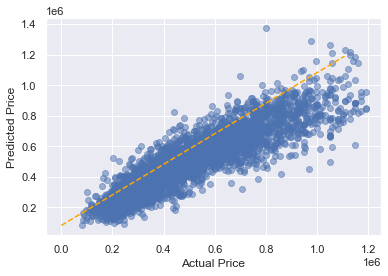

In [31]:
preds = final_model.predict(X_test)
fig, ax = plt.subplots()

perfect_line = np.arange(y_test.min(), y_test.max())
ax.plot(perfect_line, linestyle = '--', color = 'orange', label = "Perfect Fit")
ax.scatter(y_test, preds, alpha=.5)
ax.set_xlabel("Actual Price")
ax.set_ylabel("Predicted Price");

We can see this is a mostly linear model, though it does fall slightly below the line of perfect fit.

It mostly does not violate our assumption of linearity, though there are several outliers that push the line further up and affect the outcome.

# Investigating Normality

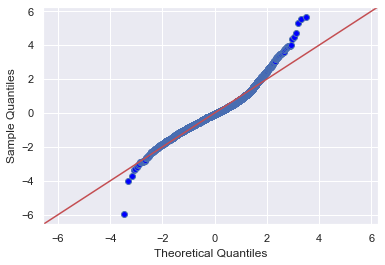

In [32]:
residuals = (y_test - y_pred)
sm.graphics.qqplot(residuals, dist=stats.norm, line='45', fit=True);

We can see that most of the residuals are normally distributed, though outliers do affect it somewhat at both tails.

# Investigating Homoscedasticity

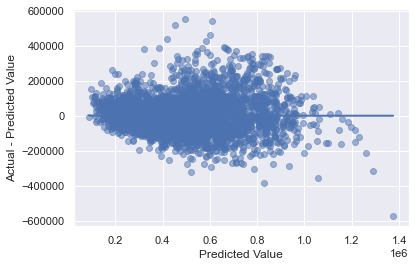

In [33]:
fig, ax = plt.subplots()

ax.scatter(preds, residuals, alpha=0.5)
ax.plot(preds, [0 for i in range(len(X_test))])
ax.set_xlabel("Predicted Value")
ax.set_ylabel("Actual - Predicted Value");

This has a good funnel shape, we might be violating a strict definition of Homoscedasticity, but likely not a general one.